In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [57]:
def load_model_data(model_name):
    """Load data for a specific model"""
    try:
        distances = pd.read_csv(f"logit_lens_results/{model_name}/cosine_similarity.csv")
        predictions = pd.read_csv(f"logit_lens_results/{model_name}/predictions.csv")
        last_layer_probs = pd.read_csv(f"logit_lens_results/{model_name}/last_layer_top_class_probs.csv")
        true_class_probs = pd.read_csv(f"logit_lens_results/{model_name}/true_class_probs.csv")
        random_class_probs = pd.read_csv(f"logit_lens_results/{model_name}/random_class_probs.csv")
        first_top_class_probs = pd.read_csv(f"logit_lens_results/{model_name}/first_top_class_probs.csv")
        divergence = pd.read_csv(f"logit_lens_results/{model_name}/kl_divergence.csv")

        return distances, predictions, last_layer_probs, true_class_probs, random_class_probs, first_top_class_probs, divergence
    except Exception as e:
        print(f"Error loading {model_name}: {e}")
        return None, None

In [58]:
def analyze_single_model_dynamics(distances_df, predictions_df, model_name):
    """Analyze dynamics for a single model"""

    layer_cols = [col for col in distances_df.columns if col.startswith('layer_')]
    layer_nums = sorted([int(col.split('_')[1]) for col in layer_cols])

    layer_stats = {}
    for layer_num in layer_nums:
        layer_col = f'layer_{layer_num}'
        similarities = distances_df[layer_col].dropna()

        layer_stats[layer_num] = {
            'mean_sim': similarities.mean(),
            'std_sim': similarities.std(),
            'median_sim': similarities.median(),
            'q25': similarities.quantile(0.25),
            'q75': similarities.quantile(0.75),
            'stability': 1 / (similarities.std() + 1e-6),
            'count': len(similarities)
        }

    # Find critical transition layers
    convergence_rates = []
    for i in range(1, len(layer_nums)):
        prev_mean = layer_stats[layer_nums[i-1]]['mean_sim']
        curr_mean = layer_stats[layer_nums[i]]['mean_sim']
        convergence_rates.append(abs(curr_mean - prev_mean))

    critical_layers = []
    if convergence_rates:
        mean_conv = np.mean(convergence_rates)
        std_conv = np.std(convergence_rates)
        critical_threshold = mean_conv + 1.5 * std_conv

        for i, rate in enumerate(convergence_rates):
            if rate > critical_threshold:
                critical_layers.append({
                    'layer': layer_nums[i+1],
                    'change_rate': rate,
                    'similarity_before': layer_stats[layer_nums[i]]['mean_sim'],
                    'similarity_after': layer_stats[layer_nums[i+1]]['mean_sim']
                })

    # === Find 3 least critical layers ===
    least_critical_info = sorted(
        zip(layer_nums[1:], convergence_rates),  # skip layer 0 since it's prev
        key=lambda x: x[1]
    )[:3]

    least_critical_layers = [{'layer': layer, 'change_rate': rate} for layer, rate in least_critical_info]

    # Calculate efficiency metrics
    similarities_sequence = [layer_stats[ln]['mean_sim'] for ln in layer_nums]

    if len(layer_nums) > 1:
        auc = np.trapz(similarities_sequence, layer_nums)
        max_possible_auc = layer_nums[-1] * 1.0
        efficiency = auc / max_possible_auc
    else:
        efficiency = similarities_sequence[0] if similarities_sequence else 0

    # Convergence analysis
    target_similarity = 0.8
    convergence_layer = None
    for i, sim in enumerate(similarities_sequence):
        if sim >= target_similarity:
            convergence_layer = layer_nums[i]
            break

    # Overall stability
    stability_scores = [layer_stats[ln]['stability'] for ln in layer_nums]
    overall_stability = np.mean(stability_scores) if stability_scores else 0

    metrics = {
        'efficiency': efficiency,
        'convergence_layer': convergence_layer,
        'final_similarity': similarities_sequence[-1] if similarities_sequence else 0,
        'similarities_sequence': similarities_sequence,
        'layer_nums': layer_nums,
        'overall_stability': overall_stability,
        'num_critical_layers': len(critical_layers),
        'max_similarity': max(similarities_sequence) if similarities_sequence else 0,
        'min_similarity': min(similarities_sequence) if similarities_sequence else 0,
        'similarity_range': max(similarities_sequence) - min(similarities_sequence) if similarities_sequence else 0,
        'least_critical_layers': least_critical_layers 
    }

    # === Summary Output ===
    print(f"\n=== SUMMARY FOR MODEL: {model_name} ===")
    print(f"• Layers analyzed: {len(layer_nums)}")
    print(f"• Final similarity: {metrics['final_similarity']:.4f}")
    print(f"• Max similarity: {metrics['max_similarity']:.4f}")
    print(f"• Min similarity: {metrics['min_similarity']:.4f}")
    print(f"• Similarity range: {metrics['similarity_range']:.4f}")
    #print(f"• Efficiency (AUC norm): {metrics['efficiency']:.4f}")
    print(f"• Overall stability: {metrics['overall_stability']:.4f}")
    print(f"• Convergence layer: {metrics['convergence_layer'] if metrics['convergence_layer'] is not None else 'Not reached'}")
    print(f"• Number of critical layers: {metrics['num_critical_layers']}")

    if critical_layers:
        critical_layer_ids = [cl['layer'] for cl in critical_layers]
        print(f"• Critical layer(s): {', '.join(map(str, critical_layer_ids))}")
    else:
        print(f"• Critical layer(s): None detected")

    if least_critical_layers:
        print("• Least critical layer(s): " + ', '.join(
            f"{l['layer']} (Δ={l['change_rate']:.4f})" for l in least_critical_layers))

    return layer_stats, critical_layers, metrics


In [59]:
def analyze_prediction_consistency(predictions_df):
    """
    Analyze how often the final label appears in earlier layers,
    track prediction stability, and evaluate probability trends.

    Returns:
        - Summary statistics printed
        - Detailed results per image
    """
    
    label_cols = [col for col in predictions_df.columns if '_label' in col]
    prob_cols = [col for col in predictions_df.columns if '_prob' in col]
    num_layers = len(label_cols)

    results = []

    for idx, row in predictions_df.iterrows():
        image_id = row['Image']
        labels = row[label_cols].values
        probs = row[prob_cols].values.astype(float)
        final_label = labels[-1]

        # First occurrence of final label
        try:
            first_occurrence = list(labels).index(final_label)
        except ValueError:
            first_occurrence = None

        # How many layers match the final label
        match_count = sum(label == final_label for label in labels[:-1])  # exclude final
        match_fraction = match_count / (num_layers - 1)

        # Plateaus: ranges of consecutive identical predictions
        plateaus = []
        current_label = labels[0]
        start_idx = 0
        for i in range(1, num_layers):
            if labels[i] != current_label:
                if i - start_idx > 1:
                    plateaus.append((start_idx, i - 1, current_label))
                start_idx = i
                current_label = labels[i]
        if num_layers - start_idx > 1:
            plateaus.append((start_idx, num_layers - 1, current_label))

        # Probability consistency (std deviation across layers)
        prob_std = np.std(probs)
        prob_max = np.max(probs)
        prob_min = np.min(probs)

        results.append({
            'Image': image_id,
            'final_label': final_label,
            'first_occurrence_of_final': first_occurrence,
            'fraction_layers_matching_final': match_fraction,
            'num_plateaus': len(plateaus),
            'plateaus': plateaus,
            'prob_std': prob_std,
            'prob_max': prob_max,
            'prob_min': prob_min,
            'prob_range': prob_max - prob_min
        })

    results_df = pd.DataFrame(results)

    # === Summary ===
    print("\n=== PREDICTION CONSISTENCY SUMMARY ===")
    total_images = len(results_df)
    early_hits = results_df['first_occurrence_of_final'].dropna().apply(lambda x: x < num_layers - 1).sum()
    print(f"• Total images: {total_images}")
    print(f"• Images where final label appeared early: {early_hits} ({(early_hits / total_images):.2%})")

    avg_first_occurrence = results_df['first_occurrence_of_final'].dropna().mean()
    print(f"• Avg. first occurrence of final label: {avg_first_occurrence:.2f} (out of {num_layers})")

    avg_match_fraction = results_df['fraction_layers_matching_final'].mean()
    print(f"• Avg. fraction of layers matching final label: {avg_match_fraction:.2f}")

    avg_plateaus = results_df['num_plateaus'].mean()
    print(f"• Avg. number of prediction plateaus per image: {avg_plateaus:.2f}")

    avg_prob_std = results_df['prob_std'].mean()
    print(f"• Avg. probability std across layers: {avg_prob_std:.4f}")

    return results_df


In [60]:

def compare_models_comprehensive():
    """Comprehensive comparison across all three models"""
    
    models = ['CLIP', 'CLIP_L', 'DINO_lp']
    model_results = {}
    
    print("=== LOADING MODEL DATA ===")
    for model in models:
        distances, predictions, last_layer_probs, true_class_probs, random_class_probs, first_top_class_probs, divergence = load_model_data(model)
        if distances is not None and predictions is not None:
            layer_stats, critical_layers, metrics = analyze_single_model_dynamics(
                distances, predictions, model
            )
            model_results[model] = {
                'layer_stats': layer_stats,
                'critical_layers': critical_layers,
                'metrics': metrics,
                'distances': distances,
                'predictions': predictions
            }
        analyzed_predictions = analyze_prediction_consistency(predictions)
    
    if not model_results:
        print("No model data loaded successfully!")
        return None
    
    print(f"\n✓ Successfully loaded {len(model_results)} models: {list(model_results.keys())}")
    
    # Create comprehensive comparison table
    print("\n=== MODEL COMPARISON SUMMARY ===")
    comparison_data = []
    
    for model_name, results in model_results.items():
        metrics = results['metrics']
        row = {
            'Model': model_name,
            'Num_Layers': len(metrics['layer_nums']),
            'Efficiency': metrics['efficiency'],
            'Final_Similarity': metrics['final_similarity'],
            'Convergence_Layer': metrics['convergence_layer'] if metrics['convergence_layer'] else 'None',
            'Critical_Layers': metrics['num_critical_layers'],
            'Overall_Stability': metrics['overall_stability'],
            'Similarity_Range': metrics['similarity_range']
        }
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.round(4).to_string(index=False))
    
    # create_multi_model_visualizations(model_results)
    # generate_comparative_insights(model_results, comparison_df)

    return model_results, comparison_df

In [61]:
def create_multi_model_visualizations(model_results):
    """Create comprehensive multi-model visualization, excluding the last layer and non-representational metrics."""

    # Set up the figure with subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1.2], hspace=0.4)

    models = list(model_results.keys())
    colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, Purple, Orange

    # 1. Similarity progression comparison
    ax1 = fig.add_subplot(gs[0, 0])

    for i, (model_name, results) in enumerate(model_results.items()):
        metrics = results['metrics']
        layer_nums = metrics['layer_nums']
        similarities = metrics['similarities_sequence'][:len(layer_nums)]

        ax1.plot(layer_nums, similarities, 'o-', linewidth=3, markersize=6,
                 color=colors[i], alpha=0.8, label=f'{model_name}')

        layer_stats = results['layer_stats']
        if layer_stats:
            stds = [layer_stats[ln]['std_sim'] for ln in layer_nums]
            ax1.fill_between(layer_nums,
                             np.array(similarities) - np.array(stds),
                             np.array(similarities) + np.array(stds),
                             alpha=0.2, color=colors[i])

    ax1.set_xlabel('Layer Number', fontsize=12)
    ax1.set_ylabel('Cosine Similarity', fontsize=12)
    ax1.set_title('Representational Convergence: Model Comparison', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)

    ax3 = fig.add_subplot(gs[2, 0])

    max_layers = max(len(results['metrics']['layer_nums']) - 1 for results in model_results.values())
    stability_matrix = np.full((len(models), max_layers), np.nan)

    layer_labels = []
    for i, (model_name, results) in enumerate(model_results.items()):
        layer_stats = results['layer_stats']
        layer_nums = results['metrics']['layer_nums'][:-1]

        for j, layer_num in enumerate(layer_nums):
            stability_matrix[i, j] = layer_stats[layer_num]['stability']

        if i == 0:
            layer_labels = [f'L{ln}' for ln in layer_nums]

    while len(layer_labels) < max_layers:
        layer_labels.append(f'L{len(layer_labels)}')

    sns.heatmap(stability_matrix,
                yticklabels=models,
                xticklabels=layer_labels[:max_layers],
                cmap='viridis',
                ax=ax3,
                cbar_kws={'label': 'Stability Score'},
                fmt='.1f')
    ax3.set_title('Layer-wise Stability Comparison', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Layer')
    ax3.set_ylabel('Model')

    plt.suptitle('Comprehensive Multi-Model Logit Lens Analysis', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()


In [62]:
def plot_cosine_similarity(distances, predictions):
    layer_names = sorted(
        [k for k in distances.keys() if k.startswith("layer_")],
        key=lambda x: int(x.split('_')[1])
    )

    try:
        similarity_values = [float(distances[layer]) for layer in layer_names]
        prob_values = [float(predictions.get(f"{layer}_prob", np.nan)) for layer in layer_names]
        predicted_labels = [predictions.get(f"{layer}_label", "") for layer in layer_names]
    except Exception as e:
        print("Error preparing data:", e)
        return

    if not all(isinstance(v, (int, float)) for v in similarity_values + prob_values):
        print("Some values are not numeric.")
        return

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 1]})

    sns.heatmap(np.array(similarity_values).reshape(1, -1), annot=True, cmap="viridis",
                xticklabels=layer_names, yticklabels=["Cosine Similarity"], cbar=True,
                ax=axes[0], cbar_kws={'label': 'Cosine Similarity'})

    sns.heatmap(np.array(prob_values).reshape(1, -1), annot=True, cmap="magma",
                xticklabels=layer_names, yticklabels=["Prediction Prob."], cbar=True,
                ax=axes[1], cbar_kws={'label': 'Prediction Probability'})

    for i, label in enumerate(predicted_labels):
        if label is not None and label != "":
            axes[1].text(i + 0.5, -0.05, str(label), ha='center', va='bottom',
                         color='black', fontsize=9, rotation=90,
                         transform=axes[1].transData)


    plt.suptitle("Cosine Similarity & Prediction Probability per Layer", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93]) 
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_metrics_for_classes(classes, model_names, data_loader_fn):
    """
    Plot average cosine similarity, KL divergence, and true class probability
    per selected class, with different plots per model and lines per class.

    Arguments:
        classes: list of class WNIDs or labels to visualize
        model_names: list of model name strings (e.g., ['CLIP', 'DINO'])
        data_loader_fn: function that takes model_name and returns:
            distances, predictions, last_layer_probs, true_class_probs,
            random_class_probs, first_top_class_probs, divergence
    """
    colors = colors = [
    '#2E86AB',  
    '#A23B72',  
    "#ED8E00",  
    '#C73E1D',  
    '#28AFB0',  
    '#6A4C93',  
    "#FFC021",  
    "#F274B7",
    "#57CA53",  
    '#3D348B', 
    ]

    fig, axs = plt.subplots(nrows=3, ncols=len(model_names), figsize=(6 * len(model_names), 15))
    metrics = ['Cosine Similarity', 'KL Divergence', 'True Class Probability']

    for model_idx, model_name in enumerate(model_names):
        distances, predictions, _, true_class_probs, _, _, divergence = data_loader_fn(model_name)

        cosine_df = pd.DataFrame(distances)
        kl_df = pd.DataFrame(divergence)
        true_prob_df = pd.DataFrame(true_class_probs)

        metric_dfs = [cosine_df, kl_df, true_prob_df]

        for row_idx, (df, ylabel) in enumerate(zip(metric_dfs, metrics)):
            ax = axs[row_idx, model_idx]

            for color_idx, cls in enumerate(classes):
                filtered = df[df['True_Label'] == cls]

                layer_data = filtered.iloc[:, 3:]  
                mean = layer_data.mean()

                color = colors[color_idx % len(colors)]
                layers = list(range(len(mean)))
                ax.plot(layers, mean, label=f"{cls}", marker='o', markersize=3, color=color)

            ax.set_title(f"{model_name} - {ylabel}")
            ax.set_xlabel("Layer")
            ax.set_ylabel(ylabel)
            ax.set_ylim(bottom=0)
            ax.legend(title="Class")

    plt.tight_layout()
    plt.show()


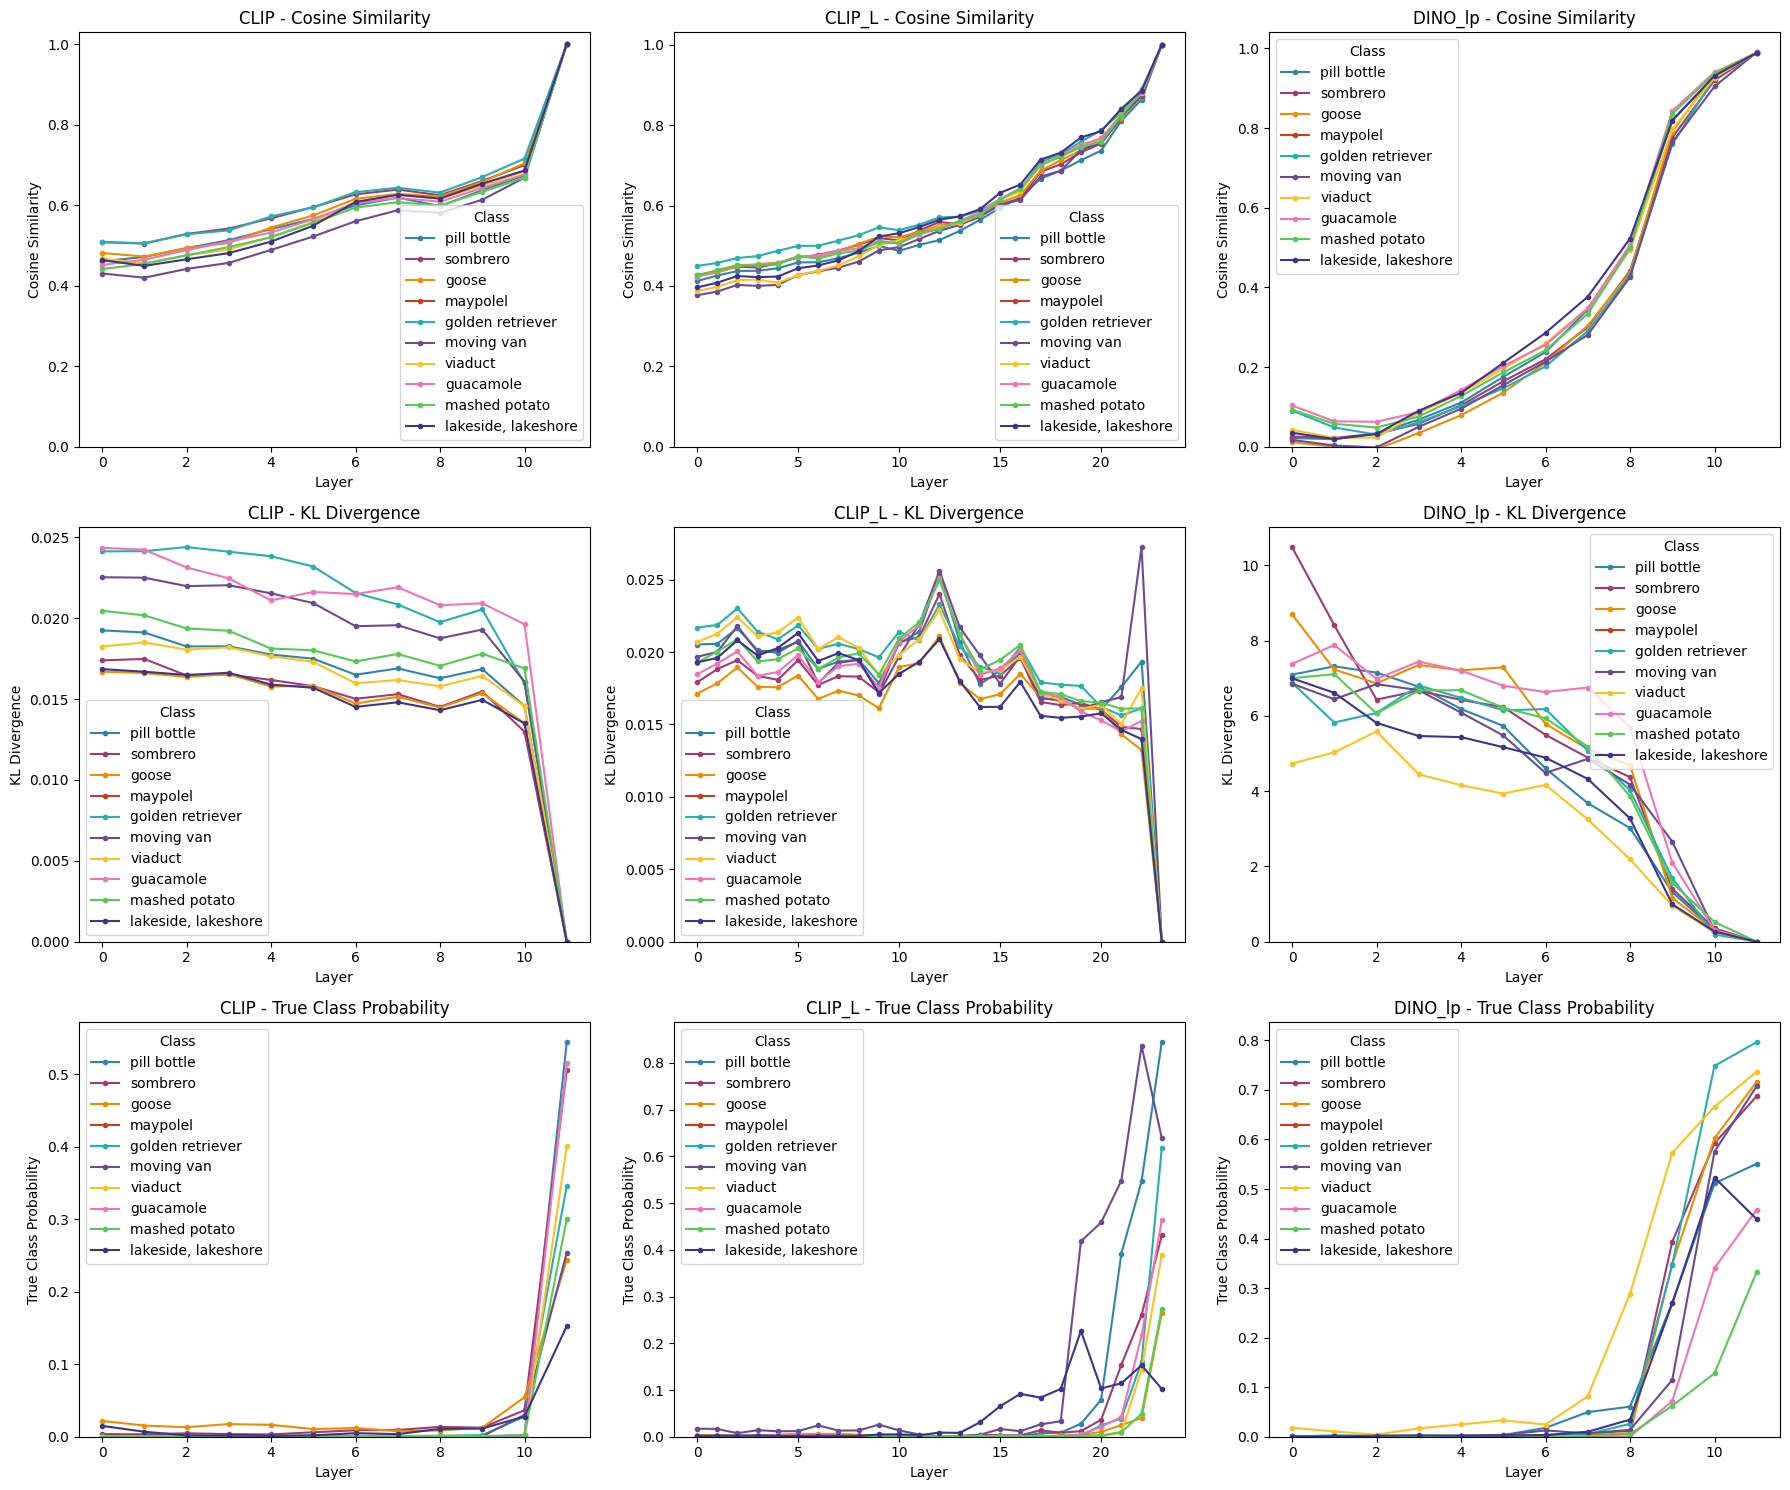

In [123]:
plot_metrics_for_classes(['pill bottle', 'sombrero', 'goose', 'maypolel', 'golden retriever', 'moving van', 'viaduct', 'guacamole','mashed potato', 'lakeside, lakeshore'], ['CLIP', 'CLIP_L', 'DINO_lp'], load_model_data)

In [64]:
def generate_comparative_insights(model_results, comparison_df):
    """Generate research insights from the comparison"""
    
    print("=== COMPARATIVE RESEARCH INSIGHTS ===\n")
    
    models = list(model_results.keys())
    
    insights = [
        f"🔍 ARCHITECTURAL DIFFERENCES:",
        f"   • Layer Count Range: {comparison_df['Num_Layers'].min()}-{comparison_df['Num_Layers'].max()} layers",
        #f"   • Efficiency Spread: {comparison_df['Efficiency'].max() - comparison_df['Efficiency'].min():.4f}",
        f"   • Stability Variation: {comparison_df['Overall_Stability'].std():.4f}",
        "",
        
        f"📊 CONVERGENCE PATTERNS:"
    ]
    
    # Analyze convergence patterns
    for model_name, results in model_results.items():
        metrics = results['metrics']
        conv_layer = metrics['convergence_layer']
        total_layers = len(metrics['layer_nums'])
        if conv_layer:
            conv_ratio = conv_layer / total_layers
            insights.append(f"   • {model_name}: Converges at layer {conv_layer}/{total_layers} ({conv_ratio:.2%})")
        else:
            insights.append(f"   • {model_name}: No convergence to 80% similarity")
    # Find best models
    best_eff_model = comparison_df.loc[comparison_df['Efficiency'].idxmax()]
    best_stab_model = comparison_df.loc[comparison_df['Overall_Stability'].idxmax()]
    
    best_efficiency = f"{best_eff_model['Model']} ({best_eff_model['Efficiency']:.4f})"
    best_stability = f"{best_stab_model['Model']} ({best_stab_model['Overall_Stability']:.4f})"
    
    for insight in insights:
        print(insight)
    
    return insights

In [65]:

def run_complete_multi_model_analysis():
    """Run the complete multi-model analysis"""
    
    print("🚀 STARTING COMPREHENSIVE MULTI-MODEL LOGIT LENS ANALYSIS")
    print("="*70)
    
    model_results, comparison_df = compare_models_comprehensive()
    
    if model_results is None:
        print("❌ Analysis failed - no data loaded")
        return None
    
    
    print("\n✅ ANALYSIS COMPLETE!")


In [70]:
results = run_complete_multi_model_analysis()


🚀 STARTING COMPREHENSIVE MULTI-MODEL LOGIT LENS ANALYSIS
=== LOADING MODEL DATA ===

=== SUMMARY FOR MODEL: CLIP ===
• Layers analyzed: 12
• Final similarity: 1.0000
• Max similarity: 1.0000
• Min similarity: 0.4737
• Similarity range: 0.5263
• Overall stability: 74564.5584
• Convergence layer: 11
• Number of critical layers: 1
• Critical layer(s): 11
• Least critical layer(s): 1 (Δ=0.0012), 3 (Δ=0.0159), 8 (Δ=0.0160)

=== PREDICTION CONSISTENCY SUMMARY ===
• Total images: 10000
• Images where final label appeared early: 683 (6.83%)
• Avg. first occurrence of final label: 10.83 (out of 12)
• Avg. fraction of layers matching final label: 0.01
• Avg. number of prediction plateaus per image: 2.32
• Avg. probability std across layers: 0.1205

=== SUMMARY FOR MODEL: CLIP_L ===
• Layers analyzed: 24
• Final similarity: 1.0000
• Max similarity: 1.0000
• Min similarity: 0.4189
• Similarity range: 0.5811
• Overall stability: 36923.9982
• Convergence layer: 21
• Number of critical layers: 1
• Cr